<a href="https://colab.research.google.com/github/MHX1203/DataWhale-DataMining/blob/master/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 特征工程主要内容

1.异常处理：
  - 通过箱线图（或 3-Sigma）分析删除异常值；
  - BOX-COX 转换（处理有偏分布）；
  - 长尾截断；


2. 特征归一化/标准化：
  - 标准化（转换为标准正态分布）；
  - 归一化（抓换到 [0,1] 区间）；
  - 针对幂率分布，可以使用公式$log(\frac{1+x}{1+median})$
3. 数据分桶
  - 等频分桶
  - 等距分桶
  - Best-KS分桶
  - 卡方分桶

4. 缺失值处理
  - 不处理(针对XGBoost类似树模型)
  - 删除(缺失值太多)
  - 插值补全，包括中位数、均值、众数或者建模预测、多重插补、压缩感知补全、矩阵补全等；
  - 分箱，缺失值单独一个箱

5. 特征特征构造
  - 构造统计量特征，报告计数、求和、比例、标准差等；
  - 时间特征，包括相对时间和绝对时间，节假日，双休日等；
  - 地理信息，包括分箱，分布编码等方法；
  - 非线性变换，包括 log/ 平方/ 根号等；
  - 特征组合，特征交叉；
  - 仁者见仁，智者见智。

6. 特征筛选
  - 过滤式（filter）：先对数据进行特征选择，然后在训练学习器，常见的方法有 Relief/方差选择发/相关系数法/卡方检验法/互信息法；
  - 包裹式（wrapper）：直接把最终将要使用的学习器的性能作为特征子集的评价准则，常见方法有 LVM（Las Vegas Wrapper）；
  - 嵌入式（embedding）：结合过滤式和包裹式，学习器训练过程中自动进行了特征选择，常见的有 lasso 回归；

7. 降维
  - PCA/ LDA/ ICA；
  - 特征选择也是一种降维。

# 导入相关库

In [0]:
import numpy as np
import pandas as pd
import os
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 200)
sns.set_style('white')
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import pandas_profiling
pd.set_option('mode.chained_assignment', None)
%matplotlib inline

# 载入数据

In [309]:
train_data = pd.read_csv('/content/drive/My Drive/Data/used_car_train_20200313.csv', sep=' ')
test_data = pd.read_csv('/content/drive/My Drive/Data/used_car_testA_20200313.csv', sep=' ')
train_data.shape, test_data.shape

((150000, 31), (50000, 30))

# 特征工程


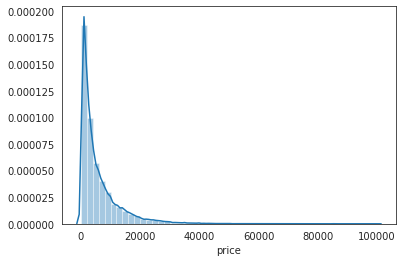

In [310]:
# 查看价格分布
sns.distplot(train_data['price'])

In [311]:
train_data['price'].skew(),train_data['price'].kurt()


(3.3464867626369608, 18.995183355632562)

价格呈现右偏。大部分机器学习方法并不能适应非正态分布的数据，可以使用log(x+1)来将非正态分布转换为正态分布

In [0]:
train_data['price'] = np.log1p(train_data['price'])

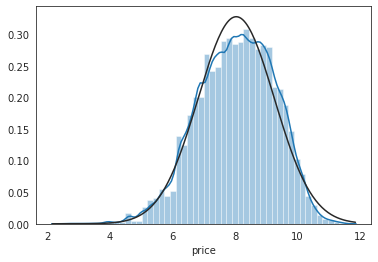

In [313]:
sns.distplot(train_data['price'], fit=norm)

In [314]:
train_data['price'].skew(),train_data['price'].kurt()

(-0.2617273589983966, -0.1821272174648949)

In [315]:
norm.fit(train_data['price'])

(8.035270518212288, 1.2182183819249919)

对power特征进行截断，大于600的重新赋值为600

In [316]:
price = train_data['price']
train_data.drop(['price'], axis=1, inplace=True)
data = pd.concat([train_data, test_data], axis=0)
data.shape

(200000, 30)

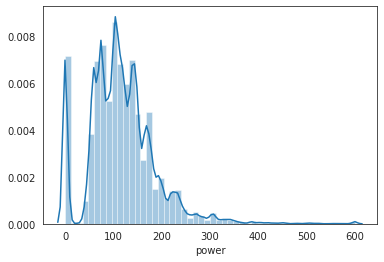

In [317]:
# idx = train_data['power'] > 600
# train_data['power'][idx] = 600
data['power'].clip(upper=600, inplace=True)
# test_data['power'].clip(upper=600, inplace=True)
sns.distplot(data['power'])

In [318]:
power = np.sqrt(data['power'])
power.skew(), power.kurt()
# sns.distplot(data['power'])

(-0.9212414037738651, 1.8088624425961597)

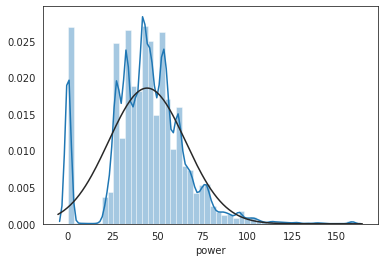

In [319]:
power1 = boxcox1p(data['power'], boxcox_normmax(data['power'] + 1))
sns.distplot(power1, fit=norm)

In [320]:
power1.skew(),power1.kurt()

(0.2985868449763486, 1.9617469142261377)

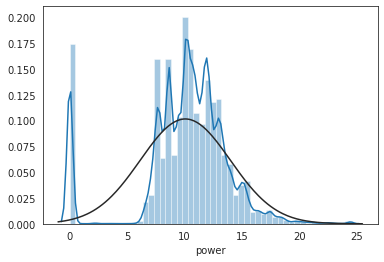

In [321]:
sns.distplot(power, fit=norm)

In [322]:
power.skew(), power.kurt()

(-0.9212414037738651, 1.8088624425961597)

In [0]:
data['power'] = boxcox1p(data['power'], boxcox_normmax(data['power'] + 1))

填充缺失值

In [0]:
def handle_missing(df):
  # df['model'] = df['model'].fill
  df_mask = df['model'].isnull()
  df['model'][df_mask] = df['model'].mode()[0]

  df_mask = df['bodyType'].isnull()
  df['bodyType'][df_mask] = df['bodyType'].mode()[0]

  df_mask = df['fuelType'].isnull()
  df['fuelType'][df_mask] = df['fuelType'].mode()[0]

  df_mask = df['model'].isnull()
  df['gearbox'][df_mask] = df['gearbox'].mode()[0]

    # df_mask = df['model'].isnull()
    # df['gearbox'][df_mask] = df['gearbox'].mode()[0]

In [0]:

handle_missing(data)
# handle_missing(test_data)

对偏度大于0.5的进行box-cox转换

In [0]:
# 查看数值特征的偏度
# digit_feats = [col for col in train_data.columns if col.startswith('v_')]
# # skews = sorted([{feat: train_data[feat].skew()} for feat in digit_feats], key=lambda x  : x.items()[1])
# skews = train_data[digit_feats].skew().sort_values()
# skews
# skews = sorted(train_data[digit_feats].skew())
# skews[:5],skews[-5:]

In [0]:
# skew_idx = pd.concat([skews.head(3), skews.tail(3)], axis=0).index
# skew_idx = skews[skews > 0.5].index
# skew_idx

进行BOX-COX 转换，必须为正数

In [0]:
# for i in skew_idx:
#   train_data[i] = boxcox1p(train_data[i], boxcox_normmax(train_data[i] + 1))


In [0]:
# from datetime import datetime
# list(map(datetime.strptime, train_data['regDate']))
# train_data['regDate'].map(lambda x: datetime.strptime(str(x), format='%Y%m%d'))
# pd.to_datetime(train_data['regDate'], format = '%Y%m%d', errors='none', )

时间处理

In [0]:
data['year'] = data['regDate'].map(lambda x: int(str(x)[:4]))
data['month'] = data['regDate'].map(lambda x: int(str(x)[4:6]))
data['day']  = data['regDate'].map(lambda x: int(str(x)[6:]))


In [330]:
# ((train_data['month'] == 0) & (train_data['day'] == 0)).index
# train_data.drop(, )
data.loc[data['month'] == 0]

SaleID    name   regDate  model  brand  bodyType  fuelType  gearbox  \
14         14    1896  20070009    1.0      0       0.0       0.0      0.0   
20         20  148669  19970004   48.0     14       1.0       0.0      0.0   
22         22  131637  19970008   26.0     14       1.0       0.0      0.0   
42         42   20694  19960009    0.0      0       4.0       0.0      0.0   
51         51  110832  20020006    5.0      5       4.0       0.0      0.0   
...       ...     ...       ...    ...    ...       ...       ...      ...   
49954  199954  175289  20000001   59.0     19       2.0       1.0      0.0   
49959  199959   55111  20010001   29.0      0       1.0       0.0      0.0   
49970  199970  139109  20030003    1.0      4       6.0       0.0      1.0   
49984  199984   82152  20080004   23.0      4       0.0       0.0      0.0   
49998  199998   96900  20020008   27.0      1       0.0       0.0      1.0   

            power  kilometer notRepairedDamage  regionCode  seller  offerType  \
14       0.000000       15.0                 -        3972       0          0   
20      25.424972       15.0               0.0         439       0          0   
22      32.745613       15.0                 -        5727       0          0   
42      37.659305       15.0               0.0        4825       0          0   
51      43.599272       15.0               1.0        5484       0          0   
...           ...        ...               ...         ...     ...        ...   
49954    0.000000       15.0                 -          60       0          0   
49959    0.000000        0.5               0.0         837       0          0   
49970   64.947244       15.0               0.0        6386       0          0   
49984   47.513550       15.0               1.0         199       0          0   
49998  101.991346       15.0               0.0        1998       0          0   

       creatDate        v_0       v_1        v_2       v_3       v_4  \
14      20160402  37.477726  4.439788  17.089898  2.969183  0.301389   
20      20160311  41.906646  2.069275  -0.678881  1.825039 -0.039355   
22      20160326  41.346476 -3.214313  -1.102793  3.629930  0.736763   
42      20160328  44.693776  2.017017  -1.479142  2.039647 -0.720858   
51      20160325  41.996992 -3.092623  -2.780618  2.706164  0.980752   
...          ...        ...       ...        ...       ...       ...   
49954   20160325  42.337480 -3.110467  -1.464165  1.680972  0.118409   
49959   20160322  42.702285 -3.197017  -0.442831  1.746883  0.442726   
49970   20160401  46.292277 -3.168672  -1.210996 -1.274996 -1.639362   
49984   20160318  38.621122 -3.748730  17.432324 -0.699746 -0.435183   
49998   20160404  46.771359 -3.296814   0.243566 -1.277411 -0.404881   

            v_5       v_6       v_7       v_8       v_9      v_10       v_11  \
14     0.000000  0.117265  1.297219  0.040885  0.020187  2.550859  18.192443   
20     0.244261  0.072858  0.088415  0.026091  0.062781 -0.863324   2.081788   
22     0.237251  0.000000  0.126609  0.017123  0.093230  4.216986   0.346678   
42     0.274547  0.074399  0.053081  0.023301  0.048611 -2.036310   0.107458   
51     0.259769  0.000000  0.000000  0.024790  0.101185  3.392746  -1.360968   
...         ...       ...       ...       ...       ...       ...        ...   
49954  0.253054  0.000000  0.067083  0.039935  0.070751  3.410604  -0.895338   
49959  0.239812  0.000000  0.137036  0.043368  0.079094  3.579323  -0.357588   
49970  0.286389  0.000467  0.045398  0.078942  0.013979  1.594302  -3.572980   
49984  0.000000  0.000419  1.317331  0.109492  0.000000  8.989997  13.422778   
49998  0.261152  0.000490  0.137366  0.086216  0.051383  1.833504  -2.828687   

           v_12      v_13      v_14  year  month  day  
14     5.145351 -0.836169  0.645098  2007      0    9  
20    -2.930227  0.249215  0.826872  1997      0    4  
22    -3.941949  0.052169 -0.157513  1997      0    8  
42    -2.330682 -1.204632 -0.022019  1996      

In [0]:

mask = data['month'] == 0
data['month'][mask] = 1

In [0]:
data['regDate'] = data['year'].map(lambda x: str(x)) + \
data['month'].map(lambda x: '0'*(2 - len(str(x))) +str(x)) + data['day'].map(lambda x: '0'*(2 - len(str(x))) +str(x))

In [333]:
data['used_time'] = pd.to_datetime('20151212', format='%Y%m%d') - pd.to_datetime(data['regDate'], format='%Y%m%d')
data.head()

SaleID    name   regDate  model  brand  bodyType  fuelType  gearbox  \
0       0     736  20040402   30.0      6       1.0       0.0      0.0   
1       1    2262  20030301   40.0      1       2.0       0.0      0.0   
2       2   14874  20040403  115.0     15       1.0       0.0      0.0   
3       3   71865  19960908  109.0     10       0.0       0.0      1.0   
4       4  111080  20120103  110.0      5       1.0       0.0      0.0   

       power  kilometer notRepairedDamage  regionCode  seller  offerType  \
0  27.579117       12.5               0.0        1046       0          0   
1   0.000000       15.0                 -        4366       0          0   
2  59.236853       12.5               0.0        2806       0          0   
3  67.343773       15.0               0.0         434       0          0   
4  30.370075        5.0               0.0        6977       0          0   

   creatDate        v_0       v_1       v_2       v_3       v_4       v_5  \
0   20160404  43.357796  3.966344  0.050257  2.159744  1.143786  0.235676   
1   20160309  45.305273  5.236112  0.137925  1.380657 -1.422165  0.264777   
2   20160402  45.978359  4.823792  1.319524 -0.998467 -0.996911  0.251410   
3   20160312  45.687478  4.492574 -0.050616  0.883600 -2.228079  0.274293   
4   20160313  44.383511  2.031433  0.572169 -1.571239  2.246088  0.228036   

        v_6       v_7       v_8       v_9      v_10      v_11      v_12  \
0  0.101988  0.129549  0.022816  0.097462 -2.881803  2.804097 -2.420821   
1  0.121004  0.135731  0.026597  0.020582 -4.900482  2.096338 -1.030483   
2  0.114912  0.165147  0.062173  0.027075 -4.846749  1.803559  1.565330   
3  0.110300  0.121964  0.033395  0.000000 -4.509599  1.285940 -0.501868   
4  0.073205  0.091880  0.078819  0.121534 -1.896240  0.910783  0.931110   

       v_13      v_14  year  month  day used_time  
0  0.795292  0.914762  2004      4    2 4271 days  
1 -1.722674  0.245522  2003      3    1 4669 days  
2 -0.832687 -0.229963  2004      4    3 4270 days  
3 -2.438353 -0.478699  1996      9    8 7034 days  
4  2.834518  1.923482  2012      1    3 1439 days

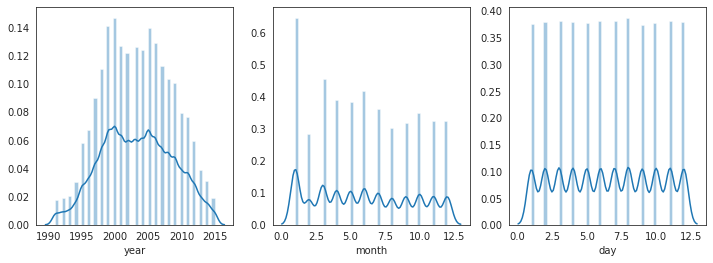

In [334]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.distplot(data['year'])
plt.subplot(1, 3, 2)
sns.distplot(data['month'])
plt.subplot(1, 3, 3)
sns.distplot(data['day'])


In [335]:
data['used_time'] = data['used_time'].map(lambda x: x.days)
data['used_time'].describe()

count    200000.000000
mean       4442.673055
std        1968.312020
min           0.000000
25%        2957.000000
50%        4475.000000
75%        5935.000000
max        9111.000000
Name: used_time, dtype: float64

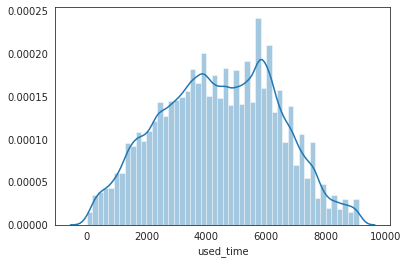

In [336]:
sns.distplot(data['used_time'])

异常值删除

In [0]:
# # 计算第一和第三 四分数
# first_quartile = train_data['power'].describe()['25%']
# third_quartile = train_data['power'].describe()['75%']

# # 第四分位数范围
# iqr = third_quartile - first_quartile

# # 去除异常值
# train_data = train_data[(train_data['power']>(first_quartile - 3*iqr)) & (train_data['power']<(third_quartile + 3*iqr))]

# sns.distplot(train_data['power'])

当我们删除异常值时，我们需要小心，我们不会因为它们看起来很奇怪就丢掉测量值。它们可能是我们应该进一步研究的实际现象的结果。 当删除异常值时，我尝试使用[极端异常值](https://people.richland.edu/james/lecture/m170/ch03-pos.html)的定义尽可能保守：

* 在低端，极端异常值低于 $\text{First Quartile} -3 * \text{Interquartile Range}$
* 在高端，极端异常值高于 $\text{Third Quartile} + 3 * \text{Interquartile Range}$

在这种情况下，我将只删除单个外围点并查看分布的形状。

In [0]:
# def drop_outlier(col):
#   global train_data
#   uniques = train_data[col].uniques()
#   for u in uniques:
#     # train_data[col] = train_data[col].astype('float64')
#     # 计算第一和第三 四分数
#     idx = train_data[col] == u
#     first_quartile = train_data[idx][col].describe()['25%']
#     third_quartile = train_data[idx][col].describe()['75%']

#     # 第四分位数范围
#     iqr = third_quartile - first_quartile

#     # 去除异常值

#     train_data[idx] = train_data[(train_data[idx][col]>(first_quartile - 3*iqr)) & \
#                                  (train_data[idx][col]<(third_quartile + 3*iqr))]

数据分箱

In [0]:
# pd.cut(train_data['regionCode'], [0, np.percentile(train_data['regionCode'], 10), 1e6], labels=range(2))

In [340]:
bining_feats = ['regionCode', 'model', 'name']
data[bining_feats].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 49999
Data columns (total 3 columns):
regionCode    200000 non-null int64
model         200000 non-null float64
name          200000 non-null int64
dtypes: float64(1), int64(2)
memory usage: 6.1 MB


In [341]:
for col in bining_feats:
  # a = data[col].astype('float64')
  bins = [np.percentile(data[col], i * 10) for i in range(11)]
  # labels = range(10)
  data[col] = pd.cut(data[col], bins=bins, labels=False)

data[bining_feats].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 49999
Data columns (total 3 columns):
regionCode    199929 non-null float64
model         184341 non-null float64
name          199992 non-null float64
dtypes: float64(3)
memory usage: 6.1 MB


In [0]:
# 对类别特征进行箱形图可视化

# 这里对不稀疏的几个特征绘制箱型图
# for c in cate_feats:
#   train_data[c] = train_data[c].astype('category')
#   if train_data[c].isnull().any():
#     train_data[c] = train_data[c].cat.add_categories(['MISSING'])
#     train_data[c] = train_data[c].fillna('MISSING')

# def boxplot(x, y, **args):
#   sns.boxplot(x=x, y=y)
#   x=plt.xticks(rotation=90)

# f = pd.melt(train_data, id_vars=['price'], value_vars=cate_feats)
# g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=10)
# g = g.map(boxplot, "value", "price")




In [0]:
# for i, feat in enumerate(cate_feats):
#   plt.subplot(3, 2, i+1)
#   sns.boxplot(train_data[feat], price)

对其他数值特征进行log(x+1)对数变换

In [0]:
digit_feats =[col for col in data.columns if col.startswith('v_')]

skews = data[digit_feats].skew().sort_values()
skew_idx = skews[np.abs(skews) > 0.5].index

In [344]:
skew_idx

Index(['v_5', 'v_0', 'v_14', 'v_11', 'v_2', 'v_7'], dtype='object')

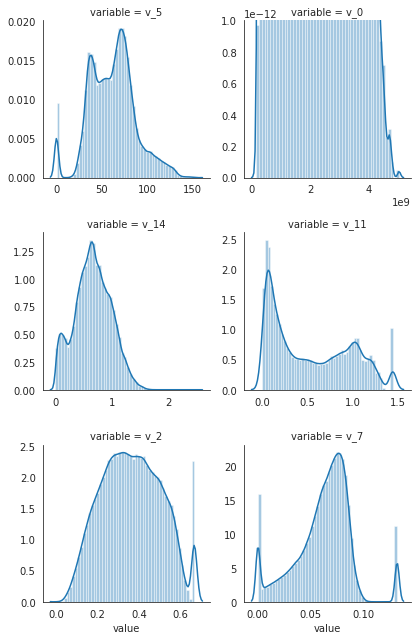

In [345]:

exp_boxcoxs = ['v_14', 'v_11', 'v_2']
for col in exp_boxcoxs:

  # train_data[col] = np.log1p(train_data[col])
  data[col] = boxcox1p(np.exp(data[col]), boxcox_normmax(np.exp(data[col]) + 1))

for col in skew_idx:
  if col not in exp_boxcoxs:
    data[col] = boxcox1p(data[col], boxcox_normmax(data[col] + 1))

f = pd.melt(data, value_vars=skew_idx)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

In [346]:
data[skew_idx].skew()

v_5     0.139216
v_0     0.095788
v_14    0.049546
v_11    0.410385
v_2     0.090911
v_7    -0.292554
dtype: float64

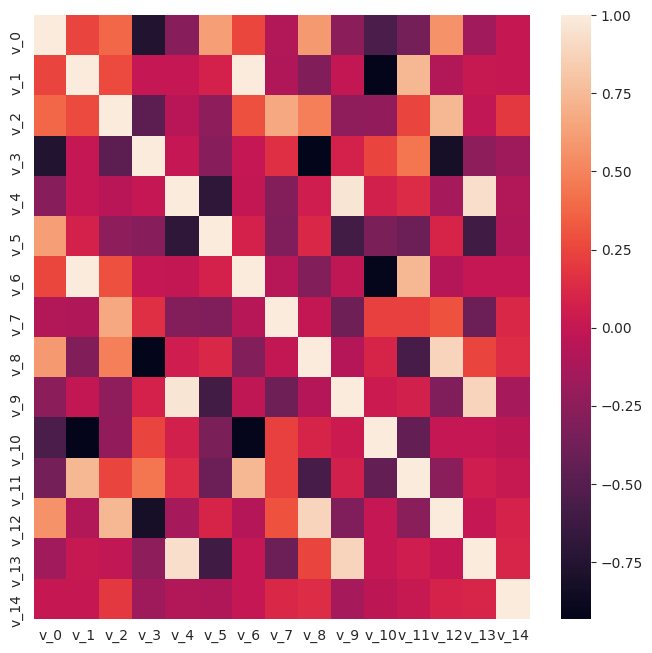

In [356]:
# train_data['price']
# correlations_data = pd.concat([data[digit_feats], pd.DataFrame(price, columns=['price'])], axis=1).corr()
correlations_data = data[digit_feats].corr()

# 打印最负相关性
# print(correlations_data,'\n')
plt.figure(figsize=(8, 8), dpi=100)
sns.heatmap(correlations_data)
# 打印最正相关性
# print(correlations_data.tail(15))

这里去掉匿变量中互相关性较大的几个变量,v_13, v_9, v_6

In [357]:
data.drop(['v_13', 'v_9', 'v_6', 'seller', 'offerType', 'notRepairedDamage', 'SaleID', 'regDate', 'creatDate'], axis=1, inplace=True)
# data.drop()
data.head()

name   regDate  model  brand  bodyType  fuelType  gearbox      power  \
0   0.0  20040402    4.0      6       1.0       0.0      0.0  27.579117   
1   1.0  20030301    5.0      1       2.0       0.0      0.0   0.000000   
2   2.0  20040403    8.0     15       1.0       0.0      0.0  59.236853   
3   5.0  19960908    8.0     10       0.0       0.0      1.0  67.343773   
4   7.0  20120103    8.0      5       1.0       0.0      0.0  30.370075   

   kilometer  regionCode  creatDate           v_0       v_1       v_2  \
0       12.5         2.0   20160404  1.648719e+09  3.966344  0.439531   
1       15.0         8.0   20160309  2.140199e+09  5.236112  0.454601   
2       12.5         6.0   20160402  2.336200e+09  4.823792  0.601498   
3       15.0         1.0   20160312  2.249734e+09  4.492574  0.421727   
4        5.0         9.0   20160313  1.894222e+09  2.031433  0.521823   

        v_3       v_4        v_5       v_7       v_8      v_10      v_11  \
0  2.159744  1.143786  35.048609  0.079530  0.022816 -2.881803  1.244643   
1  1.380657 -1.422165  76.281958  0.081653  0.026597 -4.900482  1.131569   
2 -0.998467 -0.996911  53.490583  0.090512  0.062173 -4.846749  1.071036   
3  0.883600 -2.228079  97.983481  0.076784  0.033395 -4.509599  0.943242   
4 -1.571239  2.246088  28.487008  0.064168  0.078819 -1.896240  0.835721   

       v_12      v_14  year  month  day  used_time  
0 -2.420821  0.994289  2004      4    2       4271  
1 -1.030483  0.706187  2003      3    1       4669  
2  1.565330  0.523888  2004      4    3       4270  
3 -0.501868  0.440257  1996      9    8       7034  
4  0.931110  1.424558  2012      1    3       1439

对分类特征进行独热编码（One-hot）

In [0]:
cate_feats = ['name', 'model', 'brand', 'fuelType', 'gearbox', 'regionCode', 'year', 'month',	'day']

cate_feats = pd.get_dummies(data, columns=cate_feats)

data.drop(cate_feats, axis=1, inplace=True)

data = pd.concat([data, cate_feats], axis=1)
data.head()

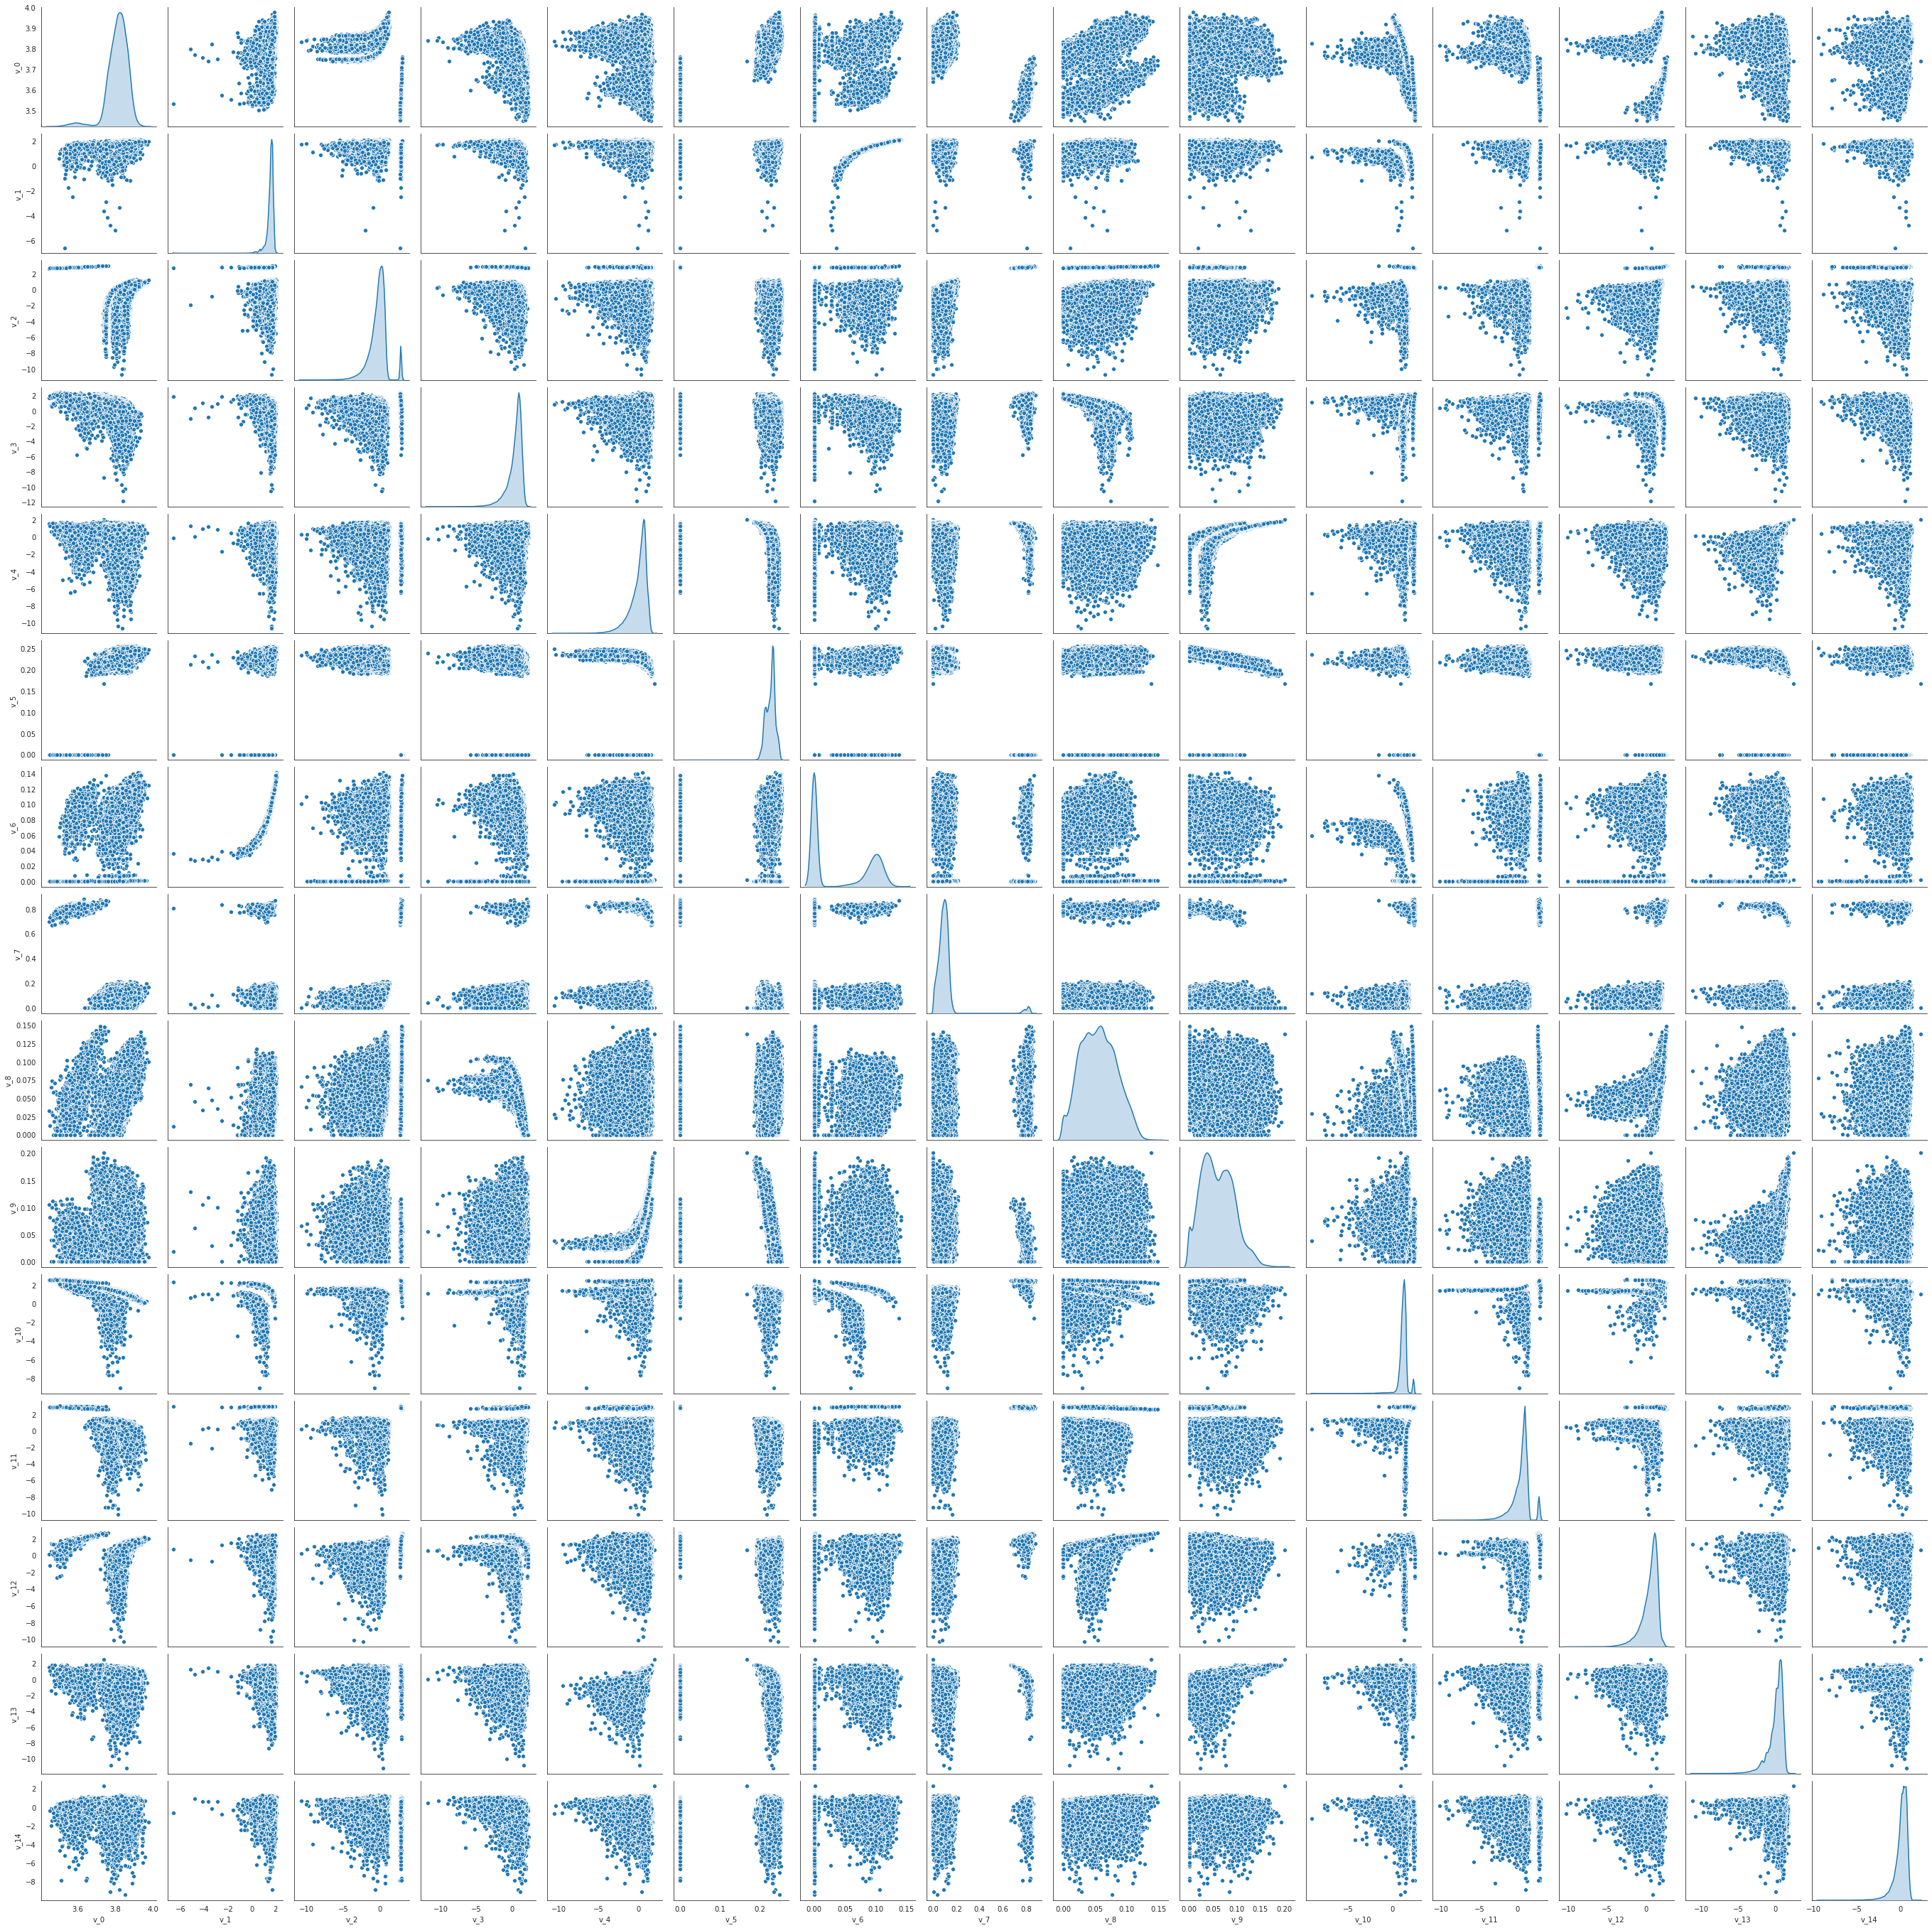

In [39]:
digit_feats = [i for i in train_data.columns if i.startswith('v_')]
sns.pairplot(train_data[digit_feats], kind ='scatter',diag_kind='kde')
plt.show()

对类别特征进行one-hot编码

